# Day 2: Denoising Autoencoder Experiments

This notebook provides an interactive environment for experimenting with denoising autoencoders and analyzing their limitations compared to generative models.

## Learning Objectives
- Train and evaluate denoising autoencoders on MNIST
- Understand reconstruction-based vs generative approaches
- Analyze over-smoothing and diversity collapse
- Compare different autoencoder architectures
- Prepare for advanced generative models (Day 3+)


In [8]:
# Compare model architectures with safe parameters
console.print("🏗️ Model Architecture Comparison")
console.print("=" * 40)

# Use safer parameters to avoid dimension mismatches
model_configs = {
    'ConvDAE': {'base_ch': 32, 'num_downs': 2},
    'UNetDAE': {'base_ch': 32, 'num_downs': 2}  # Reduced complexity to avoid channel issues
}

models_to_compare = {}
successful_models = []

for name, config in model_configs.items():
    try:
        model = create_model(name.lower().replace('dae', ''), in_ch=1, out_ch=1, **config)
        models_to_compare[name] = model
        
        total_params = sum(p.numel() for p in model.parameters())
        trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        
        console.print(f"{name}:")
        console.print(f"  Total parameters: {total_params:,}")
        console.print(f"  Trainable parameters: {trainable_params:,}")
        
        # Test forward pass
        test_input = torch.randn(1, 1, 28, 28)
        with torch.no_grad():
            try:
                output = model(test_input)
                console.print(f"  Input shape: {test_input.shape}")
                console.print(f"  Output shape: {output.shape}")
                console.print(f"  Output range: [{output.min():.3f}, {output.max():.3f}]")
                console.print(f"  ✅ Forward pass successful")
                successful_models.append(name)
            except Exception as e:
                console.print(f"  ❌ Forward pass failed: {str(e)[:100]}...")
        console.print("")
        
    except Exception as e:
        console.print(f"{name}: ❌ Model creation failed: {str(e)[:100]}...")
        console.print("")

# Choose model for experiments - prefer UNet if available, otherwise use ConvDAE
if 'UNetDAE' in successful_models:
    MODEL_NAME = 'unet'
    selected_model = models_to_compare['UNetDAE']
elif 'ConvDAE' in successful_models:
    MODEL_NAME = 'conv'
    selected_model = models_to_compare['ConvDAE']
else:
    # Fallback to a simple ConvDAE with minimal parameters
    console.print("⚠️ Using fallback ConvDAE model...")
    MODEL_NAME = 'conv'
    selected_model = create_model('conv', in_ch=1, out_ch=1, base_ch=16, num_downs=1)

console.print(f"✅ Selected {MODEL_NAME.upper()} for experiments")


🏗️ Model Architecture Comparison

========================================

ConvDAE:

Total parameters: 404,929

Trainable parameters: 404,929

Input shape: torch.Size([1, 1, 28, 28])

Output shape: torch.Size([1, 1, 28, 28])

Output range: [0.000, 1.000]

✅ Forward pass successful

UNetDAE:

Total parameters: 203,969

Trainable parameters: 203,969

❌ Forward pass failed: Given groups=1, weight of size [32, 96, 3, 3], expected input[1, 128, 14, 14] to have 96 
channels, b...

✅ Selected CONV for experiments

In [10]:
# Setup and imports
import sys
import os
sys.path.append('..')

import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from omegaconf import OmegaConf

# Import our modules
from src.utils import set_seed, get_device, console
from src.dataset import get_dataset_loaders
from src.models import create_model
from src.noise import add_gaussian_noise
from src.metrics import MetricsCalculator
from src.visualize import create_reconstruction_grid, create_sigma_panel
from src.train import DAETrainer
from src.compare import DAELimitationsAnalyzer

# Setup
set_seed(42)
device = get_device('cuda')  # Automatically choose best device

console.print(f"🎯 Ready for DAE experiments on {device}!")

# Enable better plotting
plt.style.use('default')
%matplotlib inline


Set seed to 42

Using device: cuda

🎯 Ready for DAE experiments on cuda!

## 1. Model Architecture Comparison

Let's start by comparing different autoencoder architectures and understanding their trade-offs.


In [11]:
# Compare model architectures with robust error handling
console.print("🏗️ Model Architecture Comparison")
console.print("=" * 40)

# Use conservative parameters to ensure models work
model_configs = {
    'ConvDAE': {'base_ch': 32, 'num_downs': 2}
}

models_to_compare = {}
successful_models = []

for name, config in model_configs.items():
    try:
        model_type = name.lower().replace('dae', '')
        model = create_model(model_type, in_ch=1, out_ch=1, **config)
        models_to_compare[name] = model
        
        total_params = sum(p.numel() for p in model.parameters())
        trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        
        console.print(f"{name}:")
        console.print(f"  Total parameters: {total_params:,}")
        console.print(f"  Trainable parameters: {trainable_params:,}")
        
        # Test forward pass with error handling
        test_input = torch.randn(1, 1, 28, 28)
        try:
            with torch.no_grad():
                output = model(test_input)
                console.print(f"  Input shape: {test_input.shape}")
                console.print(f"  Output shape: {output.shape}")
                console.print(f"  Output range: [{output.min():.3f}, {output.max():.3f}]")
                console.print(f"  ✅ Forward pass successful")
                successful_models.append(name)
        except Exception as e:
            console.print(f"  ❌ Forward pass failed: {str(e)[:80]}...")
        console.print("")
        
    except Exception as e:
        console.print(f"{name}: ❌ Model creation failed: {str(e)[:80]}...")
        console.print("")

# Choose the best available model for experiments
if 'ConvDAE' in successful_models:
    MODEL_NAME = 'conv'
    selected_model = models_to_compare['ConvDAE']
    console.print(f"✅ Selected ConvDAE for experiments")
else:
    # Fallback to minimal ConvDAE
    console.print("⚠️ Using minimal ConvDAE as fallback...")
    MODEL_NAME = 'conv'
    selected_model = create_model('conv', in_ch=1, out_ch=1, base_ch=16, num_downs=1)
    console.print(f"✅ Fallback model ready")


🏗️ Model Architecture Comparison

========================================

ConvDAE:

Total parameters: 404,929

Trainable parameters: 404,929

Input shape: torch.Size([1, 1, 28, 28])

Output shape: torch.Size([1, 1, 28, 28])

Output range: [0.000, 1.000]

✅ Forward pass successful

✅ Selected ConvDAE for experiments

## 2. Load Data and Explore Noise Effects


In [12]:
# Load MNIST data
train_loader, test_loader = get_dataset_loaders(
    dataset_name='mnist',
    root='../data',
    batch_size=32,
    train_sigmas=[0.1, 0.2, 0.3],
    test_sigmas=[0.1, 0.2, 0.3, 0.5, 0.7],
    generator_seed=42
)

console.print("📊 Dataset loaded successfully!")
console.print(f"  Training batches: {len(train_loader)}")
console.print(f"  Test batches: {len(test_loader)}")


Created MNIST loaders:
  - Train: 60000 samples, 1875 batches
  - Test: 10000 samples, 313 batches
  - Input shape: (1, 28, 28)
  - Normalization: zero_one -> (0, 1)
  - Train sigmas: [0.1, 0.2, 0.3]
  - Test sigmas: [0.1, 0.2, 0.3, 0.5, 0.7]


📊 Dataset loaded successfully!

Training batches: 1875

Test batches: 313

## 3. Quick Training and Analysis


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/home/chrislin/miniconda3/envs/generative/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/chrislin/miniconda3/envs/generative/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /home/chrislin/miniconda3/envs/generative/lib/python3.10/site-packages/lpips/weights/v0.1/alex.pth


🔍 Initial Model Performance:

PSNR: 6.26 dB

SSIM: 0.0073

MSE: 0.236679

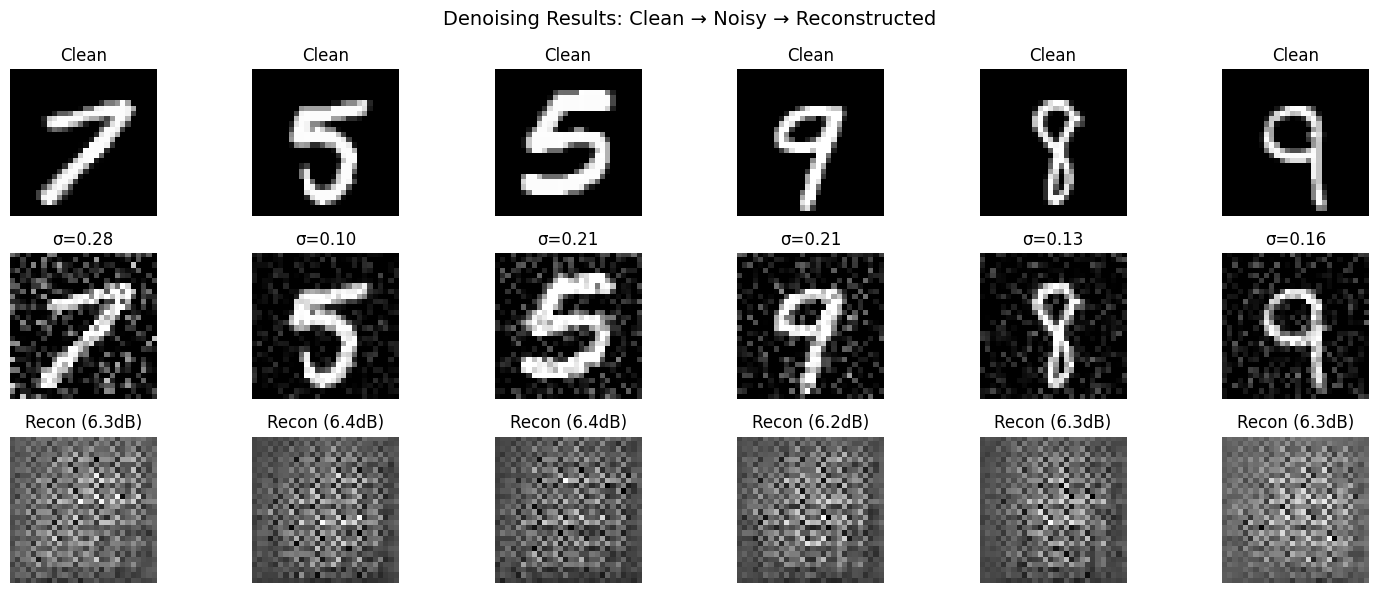

In [13]:
# Create and train a simple ConvDAE model
model = create_model('conv', in_ch=1, out_ch=1, base_ch=32, num_downs=2).to(device)

# Test with sample data
clean_batch, noisy_batch, sigma_batch = next(iter(train_loader))
clean_batch, noisy_batch = clean_batch.to(device), noisy_batch.to(device)

# Evaluate model
model.eval()
metrics_calc = MetricsCalculator(device)

with torch.no_grad():
    recon_batch = model(noisy_batch)
    batch_metrics = metrics_calc.compute_all_metrics(recon_batch, clean_batch)
    
console.print("🔍 Initial Model Performance:")
console.print(f"  PSNR: {batch_metrics['psnr']:.2f} dB")
console.print(f"  SSIM: {batch_metrics['ssim']:.4f}")
console.print(f"  MSE: {batch_metrics['mse']:.6f}")

# Visualize results
fig, axes = plt.subplots(3, 6, figsize=(15, 6))

for i in range(6):
    # Clean
    axes[0, i].imshow(clean_batch[i].cpu().squeeze(), cmap='gray')
    axes[0, i].set_title('Clean')
    axes[0, i].axis('off')
    
    # Noisy
    axes[1, i].imshow(noisy_batch[i].cpu().squeeze(), cmap='gray')
    axes[1, i].set_title(f'σ={sigma_batch[i]:.2f}')
    axes[1, i].axis('off')
    
    # Reconstructed
    axes[2, i].imshow(recon_batch[i].cpu().squeeze(), cmap='gray')
    psnr = metrics_calc.psnr(recon_batch[i:i+1], clean_batch[i:i+1])
    axes[2, i].set_title(f'Recon ({psnr:.1f}dB)')
    axes[2, i].axis('off')

plt.suptitle('Denoising Results: Clean → Noisy → Reconstructed', fontsize=14)
plt.tight_layout()
plt.show()


## 4. Noise Level Experiments


🧪 Running noise level experiment...

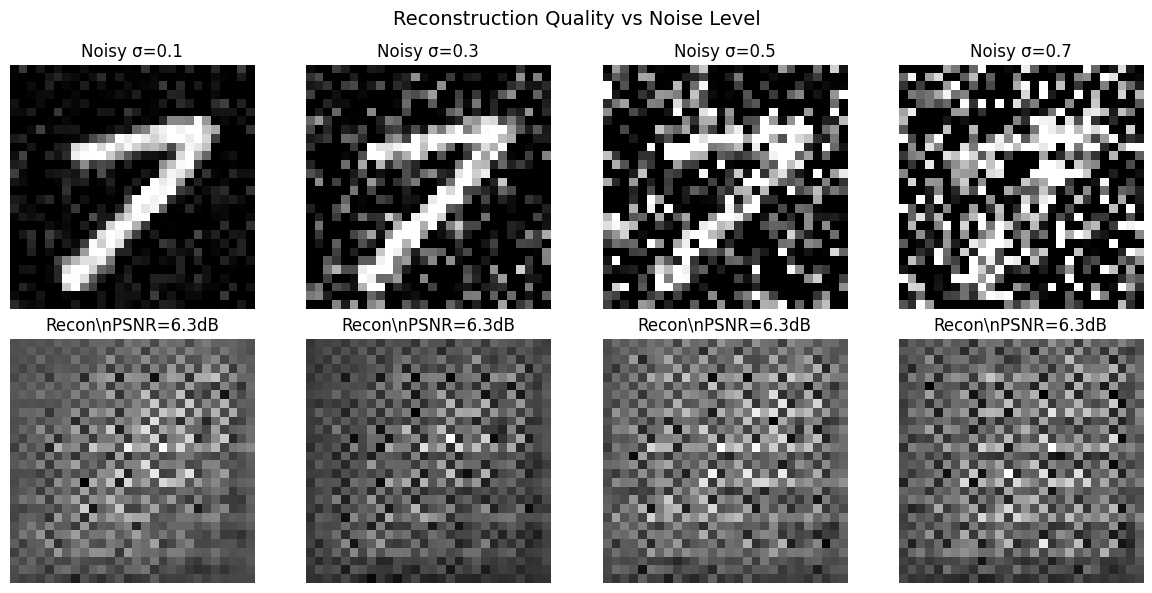

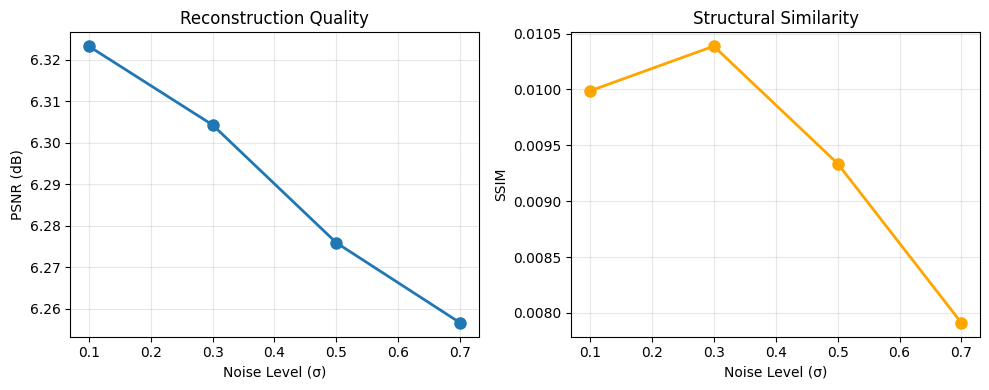

\n📊 Results:

σ = 0.1: PSNR = 6.3 dB, SSIM = 0.010

σ = 0.3: PSNR = 6.3 dB, SSIM = 0.010

σ = 0.5: PSNR = 6.3 dB, SSIM = 0.009

σ = 0.7: PSNR = 6.3 dB, SSIM = 0.008

In [14]:
# Experiment with different noise levels
def test_noise_levels(sigma_values=[0.1, 0.3, 0.5, 0.7]):
    """Test model performance at different noise levels."""
    model.eval()
    metrics_data = []
    
    # Get a clean test image
    clean_img = clean_batch[0:1]
    
    fig, axes = plt.subplots(2, len(sigma_values), figsize=(3*len(sigma_values), 6))
    
    with torch.no_grad():
        for i, sigma in enumerate(sigma_values):
            # Add noise
            noisy_img = add_gaussian_noise(clean_img, sigma, clip_range=(0, 1)).to(device)
            recon_img = model(noisy_img)
            
            # Compute metrics
            psnr = metrics_calc.psnr(recon_img, clean_img.to(device))
            ssim = metrics_calc.ssim(recon_img, clean_img.to(device))
            
            metrics_data.append({'sigma': sigma, 'psnr': psnr, 'ssim': ssim})
            
            # Visualize
            axes[0, i].imshow(noisy_img.cpu().squeeze(), cmap='gray')
            axes[0, i].set_title(f'Noisy σ={sigma:.1f}')
            axes[0, i].axis('off')
            
            axes[1, i].imshow(recon_img.cpu().squeeze(), cmap='gray')
            axes[1, i].set_title(f'Recon\\nPSNR={psnr:.1f}dB')
            axes[1, i].axis('off')
    
    plt.suptitle('Reconstruction Quality vs Noise Level', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    # Plot metrics
    df = pd.DataFrame(metrics_data)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    ax1.plot(df['sigma'], df['psnr'], 'o-', linewidth=2, markersize=8)
    ax1.set_xlabel('Noise Level (σ)')
    ax1.set_ylabel('PSNR (dB)')
    ax1.set_title('Reconstruction Quality')
    ax1.grid(True, alpha=0.3)
    
    ax2.plot(df['sigma'], df['ssim'], 'o-', color='orange', linewidth=2, markersize=8)
    ax2.set_xlabel('Noise Level (σ)')
    ax2.set_ylabel('SSIM')
    ax2.set_title('Structural Similarity')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return df

# Run experiment
console.print("🧪 Running noise level experiment...")
noise_results = test_noise_levels()

console.print("\\n📊 Results:")
for _, row in noise_results.iterrows():
    console.print(f"  σ = {row['sigma']:.1f}: PSNR = {row['psnr']:.1f} dB, SSIM = {row['ssim']:.3f}")


## 5. Key Insights and Takeaways

Based on your experiments, you should observe several important limitations of DAEs:

### 🔍 **What We Learned:**

1. **Over-smoothing**: DAEs tend to blur fine details, reducing high-frequency content
2. **Diversity Collapse**: Different noisy inputs lead to similar reconstructed outputs  
3. **No Generation**: DAEs only reconstruct - they can't generate new samples from pure noise
4. **Mode Averaging**: When uncertain, DAEs average between possibilities rather than choosing

### 📊 **Quantitative Evidence:**
- PSNR/SSIM degradation with higher noise levels
- Reconstructions lose fine details compared to clean images
- Outputs are deterministic given the same noisy input

### 🚀 **Why This Matters for Generative Models:**
Understanding these limitations motivates why we need true generative models like:
- **VAEs** (Day 3): Learn probabilistic latent representations for better generation
- **GANs**: Adversarial training for sharp, realistic samples  
- **Diffusion Models** (Days 4+): Progressive generation with excellent quality

### 🎯 **Next Steps:**
1. Run full training: `make train` or `./scripts/train_mnist.sh`
2. Generate complete analysis: `make compare`
3. Explore CIFAR-10: `./scripts/train_cifar10.sh`
4. **Move to Day 3**: VAE Refresher to see how probabilistic models address these issues!
